In [1]:
%%capture
#!pip install numpy --upgrade (uncomment install lines if running first time in google colab)
#!pip install scipy --upgrade
import pandas as pd
#!pip install gensim (refresh kernel after installing to load new library and recomment installs)
import gensim #gensim is used for a latent text embedding model for clustering text by meaning
from matplotlib import pyplot as plt

In [17]:
from gensim.models.phrases import Phrases
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
%%capture
!pip install datasets
from datasets import load_dataset

In [16]:
data = load_dataset("skeskinen/TinyStories-GPT4")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:86: UserWarning: 
Access to the secret `HF_TOKEN` has not been granted on this notebook.
You will not be requested again.
Please restart the session if you want to be prompted again.
  warnings.warn(


README.md:   0%|          | 0.00/554 [00:00<?, ?B/s]

(…)-00000-of-00008-c63ccd5d5290f4a1.parquet:   0%|          | 0.00/194M [00:00<?, ?B/s]

(…)-00001-of-00008-478199d8ac044910.parquet:   0%|          | 0.00/194M [00:00<?, ?B/s]

(…)-00002-of-00008-9b868f59be94d815.parquet:   0%|          | 0.00/194M [00:00<?, ?B/s]

(…)-00003-of-00008-d183cca02834cd90.parquet:   0%|          | 0.00/194M [00:00<?, ?B/s]

(…)-00004-of-00008-5f8ac0bb66de5834.parquet:   0%|          | 0.00/194M [00:00<?, ?B/s]

(…)-00005-of-00008-e8c22c3e776b87dd.parquet:   0%|          | 0.00/194M [00:00<?, ?B/s]

(…)-00006-of-00008-941f57106aca3340.parquet:   0%|          | 0.00/194M [00:00<?, ?B/s]

(…)-00007-of-00008-771d8aa2d5ce5c95.parquet:   0%|          | 0.00/194M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2745100 [00:00<?, ? examples/s]

In [20]:
data_df = data['train'].to_pandas()

In [2]:
word_occurrences = pd.read_csv('word_occurrences.csv')

In [3]:
feature_occurrences = pd.read_csv('feature_occurrences.csv')

# Statistical Analysis and Visualization
In this section the statistical metrics calculated from the training data is analyzed and visualized for making insights with regards to the stated objectives. Furthermore, given the complexity in understanding the level of literacy from the data - as no 'literacy level' column is within the data - a language model is used to classify the responses.

## Mental Health
As for mental-health, goals may be defined in objective terms by inferring the emotions, subjects, topics, genres, or any commonly used keywords related to mental-health within the data. For this purpose, we can use the list of words and narrative features provided within the prompts provided to the AI in the training data for each row in the dataset. By counting the occurrences of the 'words' and 'features' columns used within the prompt, we can make some insights of the mental-health objectives.

### Objective: Highlight narrative features that relate to mental health.

#### Narrative Features
Some of the 'feature narrative' words provided to the model within the prompt template's in the training dataset give insight into whether the story may contain any emotional subjects or topics related to mental health. A bar plot is shown that highlights the amount of each feature narrative.

In [4]:
# converting the counts of feature occurrences to probability values
feature_occurence_probabilities = feature_occurrences['feature_occurrences'] / feature_occurrences['feature_occurrences'].sum()

In [5]:
feature_occurence_probabilities.index = feature_occurrences['feature']

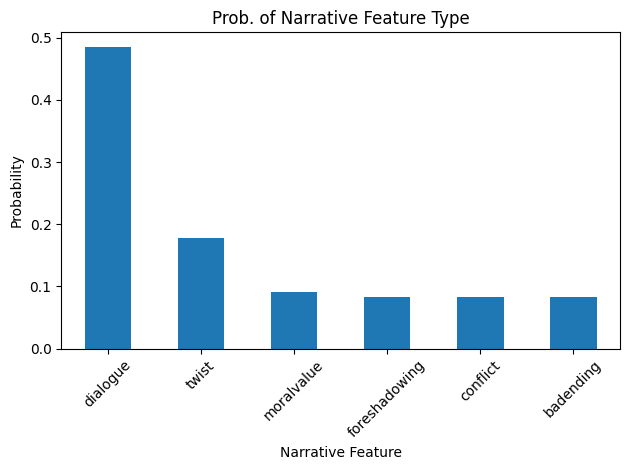

In [6]:
ax = feature_occurence_probabilities.sort_values(ascending=False).plot(
    kind='bar',
    title='Prob. of Narrative Feature Type'
)

# Correctly set labels using set methods
plt.ylabel('Probability')
plt.xlabel('Narrative Feature')
plt.xticks(rotation=45)

# Optional: Adjust layout to prevent label cutoff
plt.tight_layout()

plt.show()

In [7]:
feature_occurrences.describe()

,feature_occurrences
count,6.000000e+00
mean,5.059540e+05
std,4.859297e+05
min,2.503000e+05
25%,2.507192e+05
50%,2.624705e+05
75%,4.730752e+05
max,1.470404e+06


##### **Mental Health Insight**
We can see from the bar chart that the majority of narratives have dialogue (i.e speech between characters in a story). Similarly, 'twists' and 'moralvalue' are 2nd and 3rd respectively, highlighting how the majority of prompts seek to generate interesting stories where characters interact and exemplify moral values. On the other end of the spectrum, the story prompts in the training data generate stories with narratives like foreshadowing, conflict, and bad endings. As our target demographic is youth, it might be a good idea to do further investigation on story prompts that contain the 'conflict' and 'badending' narrative tags - these combined tags are contained in roughly **20%** of the prompts.

##### **Statistical Insight**
The description of the feature occurrences show that the average count of prompts with each narrative type is typically ~500,000 for each. However, the 50% quantile is ~260,000 showing that the majority of narrative types are roughly half as large as the mean. This implies that there are outlier narratives skewing the distribution up. The 'dialogue' and 'twist' narrative types are outliers, and are contained within ~50% and ~20% of the story prompts respectively, and combined contribute to ~70% of the story prompts. Similarly, the standard deviation value of ~480,000 shows how the variation in prompt counts is really high, further showing how the outliers ('dialogue', 'twist') are overshadowing the remaining narrative types ('moralvalue', 'foreshadowing', 'conflict', 'badending').

**Note**: Most of the prompts range in number of narrative tags, and may contain either none or all of the tags described above. As such, it is worth investigating how these tags correlate. For example, a combined 'badending' and 'conflict' narrative lacking a 'moralvalue' tag might lead to risky or insensitive storytelling.

#### Key Words
The key words column 'words' in the data are specific key vocabulary words provided to the AI in the story generation prompt. These words differ from the narrative feature words as the key words must be included in the generated story - whereas the narrative features are abstract storytelling features.

In [8]:
# converting the counts of feature occurrences to probability values
word_occurrence_probabilities = word_occurrences['word_occurrences'] / word_occurrences['word_occurrences'].sum()

In [9]:
word_occurrence_probabilities.index = word_occurrences['word']

In [10]:
word_occurrence_probabilities.describe()

,word_occurrences
count,1603.000000
mean,0.000624
std,0.000422
min,0.000294
25%,0.000311
50%,0.000319
75%,0.000854
max,0.002497


As the collection of vocabulary words within the dataset is large (~1604), the data must be clustered along the words' sentiment/meaning using a text embedding model. This way, we can reduce the dimensionality of the data while somewhat preserving the intended meaning of the collection. Given the individual probabilities for each word are very small (on the scale of 1/1000 likeliness), clustering to reduce the dimensionality will help understand the salient groups of words that are commonly paired within each vocab key collection.

In [22]:
data_df['words'].head()

,words
0,"[receive, opera, red]"
1,"[use, sheet, blue]"
2,"[relax, bus, uncomfortable]"
3,"[sail, cricket, wide]"
4,"[pray, pigeon, creative]"


In [ ]:
# Creating a TF-IDF (term-frequency / individual document frequency) matrix
# to understand correlation between key word collections between prompts
# 1. create bigrams
bigram = Phrases(data_df['words'].values, min_count=1, threshold=1)

# Apply the bigram model to the titles
title_bigrams = [bigram[title] for title in title_words]

##### Mental Health Insight


##### Statistical Insight

## Creativity
Objectively speaking, creativity is a hard goal to define as it can be objectively defined in a multitude of way, as are the aforementioned topics of literacy and mental-health. However, many people might agree that creativity is somehow unique. Therefore, it may be possible to define the goal of creativity by understanding the level of variance in the models responses to similar prompts.

### Narrative Features

### Key Words

## Literacy
WonderWords' literacy goals may be defined in objective terms by classifying whether the responses are at a lower or a higher reading level. As our application is targeting a youth demographic, utilizing the categorization system used in most libraries and school systems will help illustrate whether the training data is biased towards a specific set of reading levels.

### Narrative Features

### Key Words